In [99]:
import essentia.standard as estd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform, euclidean

#### Get audio vector and inital tempo estimation

In [8]:
path = 'money_12s.mp3'
fs = 44100
loader = estd.MonoLoader(filename=path, sampleRate= fs)
tempo_estimation_algo = estd.PercivalBpmEstimator()
audioInput = loader()
bpm = tempo_estimation_algo(audioInput)
print(bpm)

125.6648941040039


#### Compute spectrogram and 2-band energy

In [10]:
## var init
frame_size = 1024
hop_size = 512
fft_size = int(np.power(2, np.ceil(np.log2(frame_size))))

## get necessary Essentia algorithms
window_algo = estd.Windowing(normalized=True, size = frame_size, type = 'hann')
fft_algo = estd.FFT(size = fft_size)

spectrogram = []
db_spectrogram = []
print('Frame Size:', frame_size)
print('FFT Size:', fft_size)

first_note_flag = -1
for index, frame in enumerate(estd.FrameGenerator(audioInput, frameSize = frame_size, hopSize = hop_size, startFromZero = True)):
    ## spectrogram
    windowed_frame = window_algo(frame)
    mX = abs(fft_algo(windowed_frame))
    mX[mX<np.finfo(float).eps] = np.finfo(float).eps    ## if zeros add epsilon to handle log
    dbX = 20 * np.log10(mX)
    spectrogram.append(np.array(mX))
    db_spectrogram.append(np.array(dbX))
    
spectrogram = np.array(spectrogram)
db_spectrogram = np.array(db_spectrogram)
print('Spectrogram done. Size is (axis1, axis2):', spectrogram.shape)

Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (979, 513)


#### Plot Spectrogram (for visual feedback only)

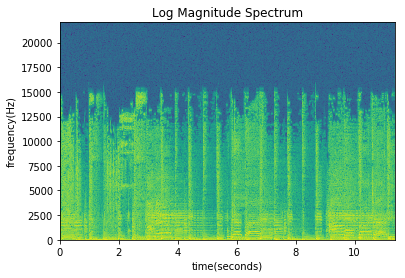

In [11]:
timeAxSec=np.arange(db_spectrogram.shape[0])*hop_size/float(fs)
freqAx_normalized=np.arange(db_spectrogram.shape[1])/float(fft_size)    #Normalized frequency axis
freqAxHz=float(fs)*freqAx_normalized

plt.pcolormesh(timeAxSec,freqAxHz,np.transpose(db_spectrogram))
plt.xlim([0,timeAxSec[-1]])
plt.ylim([0,freqAxHz[-1]])
plt.title('Log Magnitude Spectrum')
plt.ylabel('frequency(Hz)')
plt.xlabel('time(seconds)')
plt.show()

In [118]:
# beat estimation
beatTracker = estd.BeatTrackerDegara()
beats = beatTracker(audioInput)
print(beats)

print(beats * fs / hop_size)

[  0.49922901   1.02167797   1.50929701   1.99691606   2.48453522
   2.97215414   3.45977306   3.93578219   4.41179132   4.88780022
   5.36380959   5.85142851   6.33904743   6.82666636   7.30267572
   7.77868462   8.25469398   8.7307024    9.20671177   9.69433117
  10.18194962  10.65795898  11.14557838]
[  43.           88.          130.          172.          214.          256.
  297.99996948  339.          380.          420.99996948  462.          504.
  546.          588.          629.          670.          711.
  751.99993896  793.          835.          876.99993896  918.          960.        ]


In [148]:

dur_beats = []
pc8_dur_beats = [] # 8% of the duration
for i in range(len(beats)-1):
    dur_beats.append(beats[i+1] - beats[i])
    pc8_dur_beats.append(dur_beats[i] * 0.08)

avDur = np.average(dur_beats)
avDurInFrames = int(avDur * fs / hop_size)
avDur8 = np.average(pc8_dur_beats)
avDur8InFrames = int(avDur8 * fs / hop_size)
print(avDurInFrames)
print(avDur8InFrames)

framePosBeat = []
for i in range(len(beats)):
    framePosBeat.append(int((beats[i]) * fs / hop_size))

print(framePosBeat)


41
3
[42, 87, 129, 171, 214, 255, 297, 338, 379, 420, 462, 503, 545, 587, 628, 669, 711, 751, 792, 835, 876, 917, 960]


In [135]:
w, h = spectrogram.shape[0], spectrogram.shape[0]
ASM = [[1] * w for i in range(h)]

for position in framePosBeat:
    for i in range(avDurInFrames):
        
        for other in framePosBeat:
            for j in range(avDurInFrames):
                for k in range(avDur8InFrames):
                    euclidean(spectrogram[i],spectrogram[j-k])
                    if k is not 0:
                        euclidean(spectrogram[i],spectrogram[j+k])


for framesBeat in framesXbeat:
    for i in range(framesBeat[0], framesBeat[1]):
        for frame in framesXbeat:
            for j in range(frame[0], frame[1]):
                ASM[i][j] = euclidean(spectrogram[i],spectrogram[j])


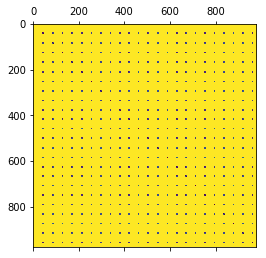

In [136]:
plt.matshow(ASM)

In [120]:
M = [[]]
for frames in framesXbeat:
    #print(frames)
    w, h = frames[0], frames[1]
    M = [[0] * w for i in range(h)]
    for i in range(frames[0], frames[1]):
        #print(str(i) + ", " + str(frames[0]))
        #print(spectrogram[frames[0]])
        #print(euclidean(spectrogram[frames[0]],spectrogram[i]))
        M[frames[0]][i] = euclidean(spectrogram[frames[0]],spectrogram[i])
    
    


plt.matshow(A)  
#print(A)

IndexError: list index out of range

In [ ]:
ASM = squareform(pdist(spectrogram))
plt.matshow(ASM)

In [156]:
ref_ASM = squareform(pdist(spectrogram))

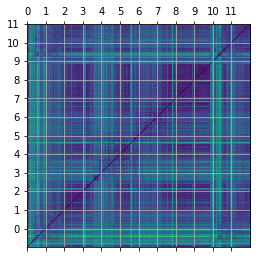

In [157]:
labels = list(range(int(len(audioInput)/fs)))
plt.matshow(ref_ASM[::-1])
stride = list(np.multiply(fs/hop_size, labels))
plt.xticks(stride, labels)
plt.yticks(stride, labels[::-1])
plt.grid(True)

In [158]:
bar_candidates = np.multiply(64, list(range(2, 13)))

In [159]:
def segment_diagonal(diagonal, bar_length):
    return [diagonal[i:i+bar_length] for i in range(0, len(diagonal), bar_length)]

In [166]:
diagonals = {}
SCS = {}
SM = {}
for bar in bar_candidates:
    diagonals[bar] = {}
    numb_diagonals = int(ref_ASM.shape[0]/bar)
    for i in range(1, numb_diagonals):
        diagonals[bar][i] = list(np.diagonal(ref_ASM, bar*i))
        diagonals[bar][i] = segment_diagonal(diagonals[bar][i], bar)
    SCS[bar] = {}
    for diagonal in range(1, numb_diagonals):
        SCS[bar][diagonal] = []
        for segment in diagonals[bar][diagonal]:
            SCS[bar][diagonal].append(math.sqrt(sum(list(np.power(segment, 2)))/len(segment)))
    SM[bar] = None
    scsi = 0
    sisi = 0
    sc = 0
    si = 0
    if len(diagonals[bar]) is 0:
        r = 0
    else: 
        r = len(diagonals[bar][1][-1])
    for diagonal in range(1, numb_diagonals):
        #for scs in SCS[bar][diagonal]:
        #print(SCS[bar][diagonal][-1])
        scsi += sum(SCS[bar][diagonal][:-1])
        sisi += SCS[bar][diagonal][-1]
        sc += len(SCS[bar][diagonal][:-1])
        si += 1
    SM[bar] = (bar*scsi + r*sisi)/(bar*sc + r*si) 

# plt.plot(range(2, 12), SM)
print(SM)
        

{128: 0.16004896674749725, 192: 0.16494929863961419, 384: 0.16559908722653116, 448: 0.17240007795250098, 320: 0.17061071378897133, 768: nan, 576: 0.17499997069925374, 640: 0.17358734105260118, 704: 0.17611571185211045, 256: 0.16329762201798081, 512: 0.16783818774756329}


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
plt.bar(range(len(SM)), list(SM.values()), align='center')
plt.xticks(range(len(SM)), list(list(SM.keys())))

In [82]:
a = [0,1,2,3]
a.append(4)
a.insert(0, -1)

In [83]:
a

[-1, 0, 1, 2, 3, 4]

1